In [58]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import os

from models.CAE import CAE
from train import Trainer

from dataloader import ElectricDevices, normalize
from utils import get_shapley_values

import hydra
from hydra.experimental import initialize, initialize_config_dir, compose

from PIL import Image

torch.manual_seed(4444)
np.random.seed(4444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Dataset

In [59]:
abs_config_dir = os.path.abspath("configs")
with initialize_config_dir(config_dir=abs_config_dir):
    cfg = compose(config_name="config")

cfg_dataset, cfg_model, cfg_train = cfg.dataset, cfg.model, cfg.train

n_train, n_valid, n_test = cfg_dataset.n_train, cfg_dataset.n_valid, cfg_dataset.n_test
n = n_train+n_valid+n_test

cfg

{'dataset': {'n_train': 1000, 'n_valid': 100, 'n_test': 100}, 'model': {'M': 4, 'Lf': 3, 'length': 96, 'bottleneck_nn': 24, 'lmd': 1e-05, 'alpha': 0.1}, 'train': {'verbose': True, 'batch_size': 128, 'shuffle': True, 'iters': 3000, 'early_stopping_rounds': 30, 'lr': 0.001}}

## Load observations

In [60]:
data_train, data_valid, data_test = ElectricDevices()

In [61]:
%%script false

n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(data_train[start+i,0])

mu, scale = 0, 0.1
data_train[:,:,:-1] += torch.normal(mu, scale, data_train[:,:,:-1].shape)
data_valid[:,:,:-1] += torch.normal(mu, scale, data_valid[:,:,:-1].shape)
data_test[:,:,:-1] += torch.normal(mu, scale, data_test[:,:,:-1].shape)

for i in range(n_plots):
    axs[1,i].axis("off")
    axs[1,i].set_title("Noisy image")
    axs[1,i].plot(data_train[start+i,0])

Couldn't find program: 'false'


In [62]:
data_train, data_valid, data_test = normalize(data_train), normalize(data_valid), normalize(data_test)
X_train, y_train = data_train[:,:,:-1], data_train[:,:,-1]
X_valid, y_valid = data_valid[:,:,:-1], data_valid[:,:,-1]
X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1]

# Data Exploration

# Compare to baseline

In [63]:
%%script false

X_train, y_train = data_train[:,0,:-1], data_train[:,0,-1].numpy()
X_valid, y_valid = data_valid[:,0,:-1], data_valid[:,0,-1].numpy()
X_test, y_test = data_test[:,0,:-1], data_test[:,0,-1].numpy()
y_train.astype(int)
y_valid.astype(int)
y_test.astype(int)

best_acc = 0
best_k = 0
for i in range(1,50):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)

    y_validp = neigh.predict(X_valid)
    y_validp.astype(int)

    acc = np.sum(y_validp == y_valid)/len(y_valid)
    if best_acc < acc:
        best_acc = acc
        best_k = i
print("Best k:", best_k)
print("Accuracy:", best_acc)

Couldn't find program: 'false'


In [64]:
%%script false

neigh = KNeighborsClassifier(n_neighbors=best_k)
X_aux = np.r_[X_train, X_valid]
y_aux = np.r_[y_train, y_valid]
neigh.fit(X_aux, y_aux)

y_testp = neigh.predict(X_test)
y_testp.astype(int)

cm = confusion_matrix(y_test, y_testp)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
print("Accuracy:", np.sum(np.diag(cm))/np.sum(cm))

Couldn't find program: 'false'


# Model

In [65]:
model = CAE(cfg_model, num_classes=7)

In [66]:
#%%script false

trainer = Trainer(cfg_train)
train_losses, valid_losses = trainer.fit(model, data_train, data_valid)

EPOCH 10 train loss: 0.35188220345204874, valid loss: 0.35118352249264717
epochs without improvement: 0

EPOCH 20 train loss: 0.32875195914699185, valid loss: 0.3335593305528164
epochs without improvement: 1

EPOCH 30 train loss: 0.31817231351329434, valid loss: 0.32284896820783615
epochs without improvement: 0

EPOCH 40 train loss: 0.3095501430573002, valid loss: 0.31574732437729836
epochs without improvement: 0

EPOCH 50 train loss: 0.30375248241809105, valid loss: 0.31474317982792854
epochs without improvement: 1

EPOCH 60 train loss: 0.29885174382117485, valid loss: 0.30855948477983475
epochs without improvement: 0

EPOCH 70 train loss: 0.2944923821956881, valid loss: 0.3066524341702461
epochs without improvement: 1

EPOCH 80 train loss: 0.2895729287016776, valid loss: 0.30395320802927017
epochs without improvement: 1

EPOCH 90 train loss: 0.28743172797464556, valid loss: 0.299332819879055
epochs without improvement: 2

EPOCH 100 train loss: 0.28280332059629504, valid loss: 0.29949

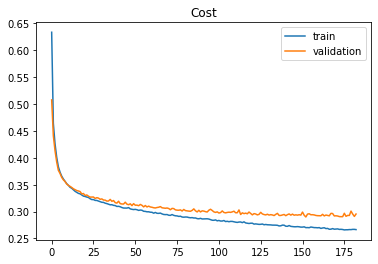

In [67]:
#%%script false

plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [76]:
#torch.save(model.state_dict(), "../saved_models/mod")
#model.load_state_dict(torch.load("../saved_models/mod"))

<All keys matched successfully>

# Shapley Values

In [183]:
inp = X_test[1].reshape((-1,1,96))

sv_vec = []
for i in range(96):
    print(i)
    sv = get_shapley_values(model, inp, target=i)[0,0]
    sv_vec.append(sv)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [184]:
ylim = (np.min(sv_vec),1)
for i in range(96):
    plt.plot(sv_vec[i].flatten())
    plt.plot(inp.detach().numpy().flatten())
    plt.title(f"Position {i}")
    plt.ylim(ylim)
    plt.axvline(x=i, c="red")
    plt.savefig(f"../plots/{i}.png")
    plt.close()

# Testing

## Average and std correlation

avg and std: 0.4511342814572371 0.19472157994055986

cor: 0.3005554996672202
cor: 0.5229712055373883
cor: 0.7674095285110221
cor: 0.3443748018494708
cor: 0.4259827216841795


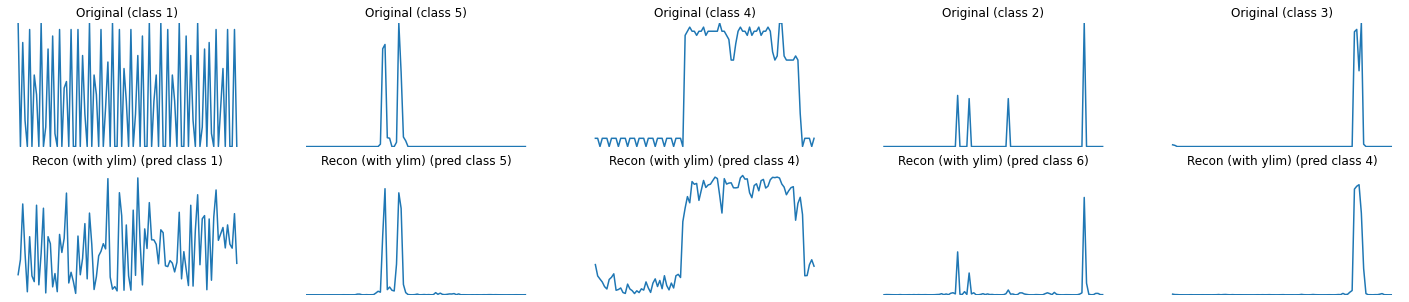

In [78]:
X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1].numpy()
X_testp, outclass_testp, bn = model(X_test)
X_testp = X_testp.detach().numpy()
probs_testp = torch.nn.functional.softmax(outclass_testp, dim=1)
y_testp = torch.argmax(probs_testp, dim=1).detach().numpy()

# avg and std of cors
cors = [scipy.stats.spearmanr(X_testp[i,0], X_test[i,0]).correlation for i in range(n_test)]
print("avg and std:", np.mean(cors), np.std(cors))
print()

# plots
n_plots = 5
start = 0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    axs[0,i].set_title(f"Original (class {int(y_test[n_plots*start+i][0])})")
    axs[0,i].plot(X_test[n_plots*start+i,0])
    axs[0,i].axis("off")
    axs[0,i].set_ylim((0,1))

    axs[1,i].set_title(f"Recon (with ylim) (pred class {int(y_testp[n_plots*start+i])})")
    axs[1,i].plot(X_testp[n_plots*start+i,0])
    axs[1,i].axis("off")
    axs[1,i].set_ylim((0,1))

    print("cor:", scipy.stats.spearmanr(X_testp[start+i,0], X_test[start+i,0]).correlation)

Accuracy: 0.606795486966671


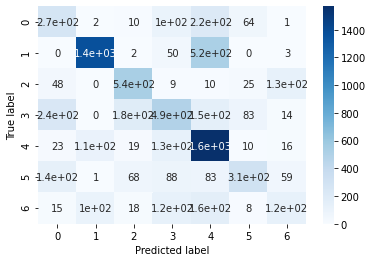

In [79]:
cm = confusion_matrix(y_test, y_testp)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

print("Accuracy:", np.sum(np.diag(cm))/np.sum(cm))

# Checking important filters

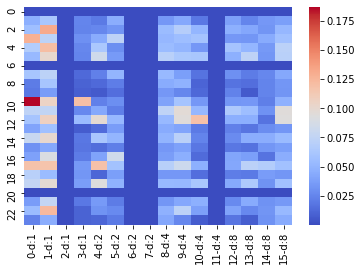

In [77]:
num_filter = model.k*model.M
w_per_filter = model.length
num_neurons = model.bottleneck_nn
M = model.M

w = np.array([[torch.mean(torch.abs(model.full_conv_bn.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{model.dilation[i//M]}" for i in range(w.shape[1])]
_ = sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels)